# NLP Project IDCamp X Dicoding: Bike Rent Analysis (Hour)

- Name: Fajrul Iman Giat Koentjoro
- Email: fajrul.10.9e@gmail.com

## Preparing TPU

In [ ]:
# Activating TPU
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  tpu = None
  print('TPU not found')

# Initiating TPU
if tpu != None:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.78.254.130:8470']


## Importing Library and Necessity

In [ ]:
# Importing Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile, os
import math
import tensorflow as tf

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GlobalAveragePooling1D, Dropout, BatchNormalization, Bidirectional
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger

In [ ]:
!wget --no-check-certificate 'https://drive.usercontent.google.com/u/0/uc?id=1RaBmV6Q6FYWU4HWZs80Suqd7KQC34diQ&export=download' -O /content/dataset.zip

--2024-02-14 10:25:00--  https://drive.usercontent.google.com/u/0/uc?id=1RaBmV6Q6FYWU4HWZs80Suqd7KQC34diQ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.120.132, 2607:f8b0:4001:c2e::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.120.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1RaBmV6Q6FYWU4HWZs80Suqd7KQC34diQ&export=download [following]
--2024-02-14 10:25:00--  https://drive.usercontent.google.com/uc?id=1RaBmV6Q6FYWU4HWZs80Suqd7KQC34diQ&export=download
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1RaBmV6Q6FYWU4HWZs80Suqd7KQC34diQ&export=download [following]
--2024-02-14 10:25:00--  https://drive.usercontent.google.com/download?id=1RaBmV6Q6FYWU4HWZs80Suqd7KQC34diQ&export=download
Reusing e

## Loading Dataset

In [ ]:
# Extracting Dataset
local_zip = "/content/dataset.zip"

zip_reff = zipfile.ZipFile(local_zip, 'r')
zip_reff.extractall("/content")
zip_reff.close()

In [ ]:
#Reading the dataset
raw_df = pd.read_csv('/content/hour.csv')
raw_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Exoloratory Data Analysis

### Cleaning the Data

In [ ]:
df = raw_df.copy()
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


From the information above, it is known that the features "dteday" and "h" can be used as a source of datetime-based information

In [ ]:
# Creating a datetime type index from dteday and h
df.index = pd.to_datetime(df['dteday']) + pd.to_timedelta(df['hr'], unit='h')
df.index.name = 'Timestamp'
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
Timestamp,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
print("==========Check Null Data==========")
df.isnull().sum()

==========Check Null Data==========


instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

From the information above, it is known that there is no null data in the dataset used

In [ ]:
# Checking the correlation between each feature and cnt
df.corr()['cnt']

<ipython-input-10-8c8af8a2d88a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['cnt']


instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

From the information above, it is known that temp (temperature) and hum (humidity) have a high correlation with cnt (total rental)

In [ ]:
# Creating dataframe for time series modeling
ts_df = df[['temp', 'hum', 'cnt']].copy()
ts_df.head()

,temp,hum,cnt
Timestamp,,,
2011-01-01 00:00:00,0.24,0.81,16
2011-01-01 01:00:00,0.22,0.80,40
2011-01-01 02:00:00,0.22,0.80,32
2011-01-01 03:00:00,0.24,0.75,13
2011-01-01 04:00:00,0.24,0.75,1


The scale of the temp and hum data is not in its original scale. From the dataset documentation, it is known that to get the original scale of temp and hum, temp can be multiplied by 41 and hum by 100

In [ ]:
# Inverting the scale of temp and hum
ts_df['temp'] = ts_df['temp']*41
ts_df['hum'] = ts_df['hum']*100
ts_df.head()

,temp,hum,cnt
Timestamp,,,
2011-01-01 00:00:00,9.84,81.0,16
2011-01-01 01:00:00,9.02,80.0,40
2011-01-01 02:00:00,9.02,80.0,32
2011-01-01 03:00:00,9.84,75.0,13
2011-01-01 04:00:00,9.84,75.0,1


<Axes: xlabel='Timestamp'>

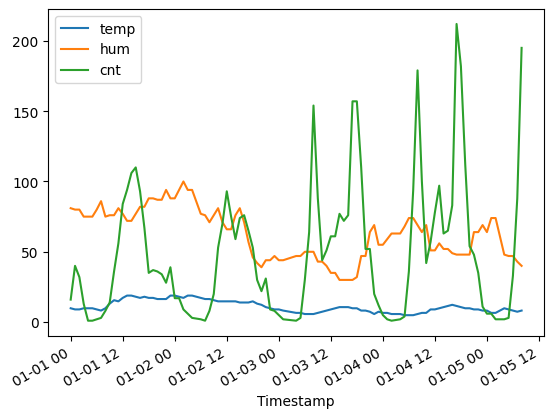

In [ ]:
plot = ts_df[:100]
plot.plot()

In [ ]:
# Implementing standarization to make the graph look better
standard_scaler = StandardScaler()
scaled_df =  standard_scaler.fit_transform(ts_df)
scaled_df = pd.DataFrame(scaled_df, columns=ts_df.columns, index=ts_df.index)
scaled_df.head()

,temp,hum,cnt
Timestamp,,,
2011-01-01 00:00:00,-1.334648,0.947372,-0.956339
2011-01-01 01:00:00,-1.438516,0.895539,-0.824022
2011-01-01 02:00:00,-1.438516,0.895539,-0.868128
2011-01-01 03:00:00,-1.334648,0.636370,-0.972879
2011-01-01 04:00:00,-1.334648,0.636370,-1.039037


<Axes: xlabel='Timestamp'>

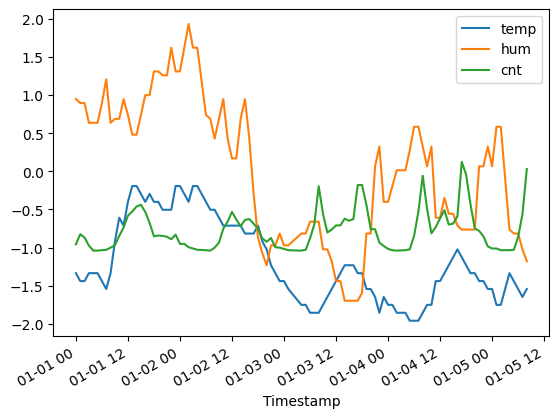

In [ ]:
plot = scaled_df
plot[:100].plot()

### Data Pre-processing

<Axes: xlabel='Timestamp'>

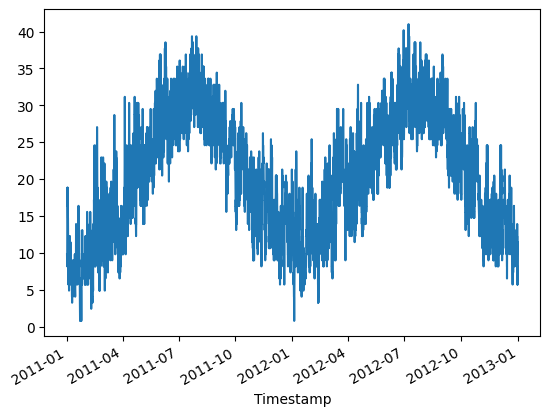

In [ ]:
ts_df['temp'].plot()

From the information above and general knowledge, it is known that temperature has a cyclical nature phenomenon. So, it must be beneficial if we represent this as features that can improve the accuracy of our model.

In [ ]:
# Convert the index to seconds since the Unix epoch
ts_df['Seconds'] = ts_df.index.map(pd.Timestamp.timestamp)

# Define the number of seconds in a day and a year
SECONDS_IN_DAY = 60*60*24
SECONDS_IN_YEAR = 365.2425*SECONDS_IN_DAY

# Create new columns in the DataFrame for the sine and cosine values of the day and year
# This is done to capture the cyclical nature of these time periods
ts_df['Day sin'] = np.sin(ts_df['Seconds'] * (2* np.pi / SECONDS_IN_DAY))
ts_df['Day cos'] = np.cos(ts_df['Seconds'] * (2 * np.pi / SECONDS_IN_DAY))
ts_df['Year sin'] = np.sin(ts_df['Seconds'] * (2 * np.pi / SECONDS_IN_YEAR))
ts_df['Year cos'] = np.cos(ts_df['Seconds'] * (2 * np.pi / SECONDS_IN_YEAR))

# Display the first few rows of the DataFrame
ts_df.head()

,temp,hum,cnt,Seconds,Day sin,Day cos,Year sin,Year cos
Timestamp,,,,,,,,
2011-01-01 00:00:00,9.84,81.0,16,1.293840e+09,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,9.02,80.0,40,1.293844e+09,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,9.02,80.0,32,1.293847e+09,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,9.84,75.0,13,1.293851e+09,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,9.84,75.0,1,1.293854e+09,8.660254e-01,0.500000,0.003856,0.999993


In [ ]:
# Removing column 'Seconds'. It is not needed in training
ts_df.drop(['Seconds'], axis='columns', inplace=True)
ts_df.head()

,temp,hum,cnt,Day sin,Day cos,Year sin,Year cos
Timestamp,,,,,,,
2011-01-01 00:00:00,9.84,81.0,16,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,9.02,80.0,40,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,9.02,80.0,32,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,9.84,75.0,13,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,9.84,75.0,1,8.660254e-01,0.500000,0.003856,0.999993


In [ ]:
# Function for creating time series dataset
def windowed_dataset(series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size)

In [ ]:
# with tpu_strategy.scope():
data = windowed_dataset(ts_df.values, 9, 2)

# Converting Tensorflow dataset into array numpy
X = np.array(list(data.map(lambda X, y: X).as_numpy_iterator()))
y = np.array(list(data.map(lambda X, y: y).as_numpy_iterator())) [:, :, :, [0,2]]

Exception ignored in: <function Executor.__del__ at 0x7bdc0c1a6170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7bdc0c1a6170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [ ]:
print(X.shape, y.shape)

(8685, 2, 9, 7) (8685, 2, 1, 2)


In [ ]:
print([(X.shape, y.shape) for X, y in data.take(1)])

Exception ignored in: <function Executor.__del__ at 0x7bdc0c1a6170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


[(TensorShape([2, 9, 7]), TensorShape([2, 1, 7]))]


In [ ]:
# Split the data into training data and test/validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6948, 2, 9, 7) (1737, 2, 9, 7) (6948, 2, 1, 2) (1737, 2, 1, 2)


In [ ]:
# Function for standarization
def standarization (data_train, data_test, index_feature=None):
  data_train = np.copy(data_train)
  data_test = np.copy(data_test)
  scalers = {}

  if index_feature == None:
    index_feature = range(0, data_train.shape[3])
  for i in index_feature:
    scaler = StandardScaler()
    origin_train_shape = data_train[:, :, :, i].shape
    origin_test_shape = data_test[:, :, :, i].shape
    data_train[:, :, :, i] = scaler.fit_transform(data_train[:, :, :, i].reshape(-1,1)).reshape(origin_train_shape)
    data_test[:, :, :, i] = scaler.transform(data_test[:, :, :, i].reshape(-1,1)).reshape(origin_test_shape)
    scalers[i] = scaler
  return data_train, data_test, scalers

In [ ]:
# Doing the standarizarion to data trian dan test
scaled_X_train, scaled_X_test, _ = standarization(X_train, X_test, index_feature=[0, 1, 2])
scaled_y_train, scaled_y_test, scaler_y = standarization(y_train, y_test)

In [ ]:
print(scaled_X_train.shape, scaled_X_test.shape, scaled_y_train.shape, scaled_y_test.shape)

(6948, 2, 9, 7) (1737, 2, 9, 7) (6948, 2, 1, 2) (1737, 2, 1, 2)


In [ ]:
# Packing the dataset into Tensorflow dataset
tensor_train = tf.data.Dataset.from_tensor_slices((scaled_X_train, scaled_y_train)) #.prefetch(1)
tensor_test = tf.data.Dataset.from_tensor_slices((scaled_X_test, scaled_y_test)) #.prefetch(1)

In [ ]:
print([(X.shape, y.shape) for X, y in tensor_train.take(1)])

Exception ignored in: <function Executor.__del__ at 0x7bdc0c1a6170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


[(TensorShape([2, 9, 7]), TensorShape([2, 1, 2]))]


## Modeling

In [ ]:
# Creating the sequential model and runing it on TPU
with tpu_strategy.scope():
  model = Sequential([
    Bidirectional(LSTM(60, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dropout(0.2),
    Dense(2, 'linear'),
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-04) #momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])

In [ ]:
# Callback for saving best model
checkpoint = ModelCheckpoint('model/', save_best_only=True)

# Callback for saving log
csv_logger = CSVLogger('training_history.csv', separator=',', append=False)

# Callback for Learning rate scheduler
initial_learning_rate = 1.0000e-04

def lr_step_decay(epoch, lr):
    drop_rate = 0.7
    epochs_drop = 10
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

### Training

In [33]:
# Fit the model on TPU
num_epochs = 40
# num_batch = 64

with tpu_strategy.scope():
  history = model.fit(tensor_train,
                      epochs=num_epochs,
                      # batch_size=num_batch,
                      validation_data=(tensor_test),
                      verbose=2,
                      callbacks=[[LearningRateScheduler(lr_step_decay),
                                  # checkpoint,
                                  csv_logger]]
            )

Epoch 1/40
6948/6948 - 100s - loss: 0.1062 - mae: 0.3395 - val_loss: 0.1236 - val_mae: 0.3460 - lr: 1.0000e-04 - 100s/epoch - 14ms/step
Epoch 2/40
6948/6948 - 86s - loss: 0.0913 - mae: 0.3124 - val_loss: 0.0912 - val_mae: 0.3024 - lr: 1.0000e-04 - 86s/epoch - 12ms/step
Epoch 3/40
6948/6948 - 89s - loss: 0.0859 - mae: 0.3030 - val_loss: 0.0737 - val_mae: 0.2600 - lr: 1.0000e-04 - 89s/epoch - 13ms/step
Epoch 4/40
6948/6948 - 85s - loss: 0.0831 - mae: 0.2980 - val_loss: 0.0670 - val_mae: 0.2556 - lr: 1.0000e-04 - 85s/epoch - 12ms/step
Epoch 5/40
6948/6948 - 84s - loss: 0.0802 - mae: 0.2916 - val_loss: 0.0578 - val_mae: 0.2399 - lr: 1.0000e-04 - 84s/epoch - 12ms/step
Epoch 6/40
6948/6948 - 84s - loss: 0.0762 - mae: 0.2845 - val_loss: 0.0491 - val_mae: 0.2206 - lr: 1.0000e-04 - 84s/epoch - 12ms/step
Epoch 7/40
6948/6948 - 85s - loss: 0.0751 - mae: 0.2819 - val_loss: 0.0476 - val_mae: 0.2213 - lr: 1.0000e-04 - 85s/epoch - 12ms/step
Epoch 8/40
6948/6948 - 85s - loss: 0.0752 - mae: 0.2806 - va

### Visualization/Evaluation

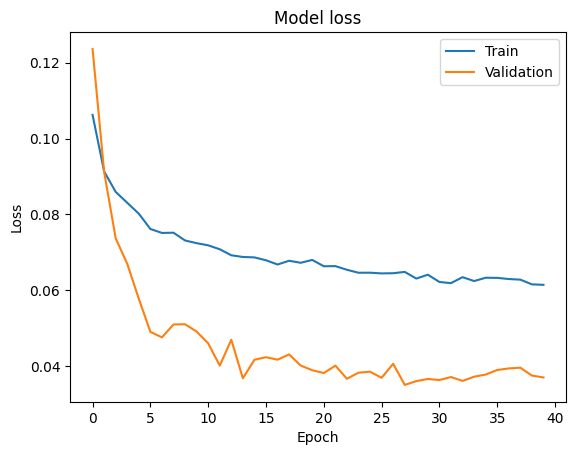

In [34]:
# Visualizing the loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

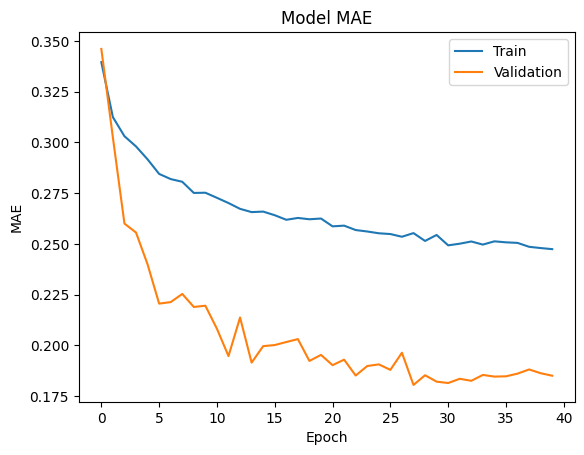

In [35]:
# Visualizing the MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1737/1737 [==============================] - 19s 10ms/step


Exception ignored in: <function Executor.__del__ at 0x7bdc0c1a6170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


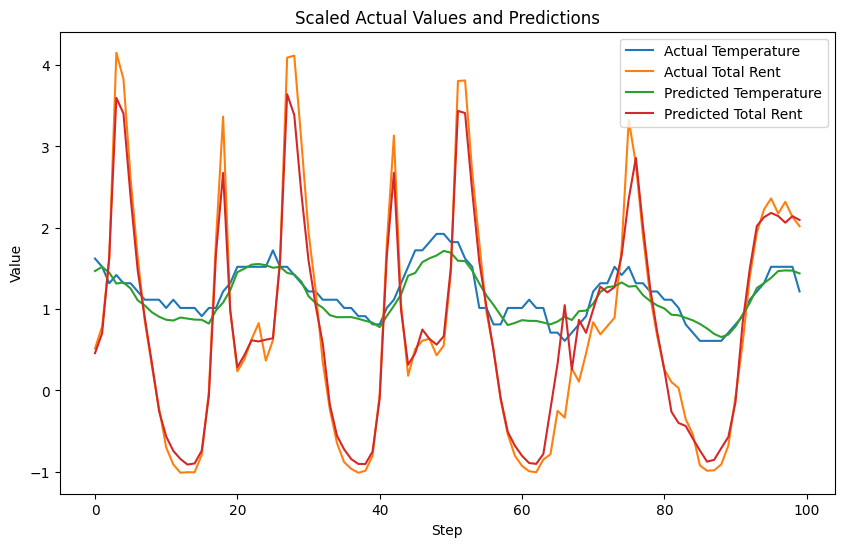

In [40]:
# Doing prediction
predictions = model.predict(tensor_test)

# Unpack the actual y/y_test
actual = []
for _, y in tensor_test:
    actual.extend(y.numpy())
actual = np.squeeze(actual)

# Membuat plot
plt.figure(figsize=(10, 6))

plt.plot(actual[:100], label=['Actual Temperature', 'Actual Total Rent'])
plt.plot(predictions[:100], label=['Predicted Temperature', 'Predicted Total Rent'])

plt.title('Scaled Actual Values and Predictions')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()

plt.show()

In [41]:
print("==================MAE'S THERSHOLD==================")
threshold_mae = (scaled_df.max() - scaled_df.min()) * 10/100
print(threshold_mae[[0, 2]])

print("==================MAE==================")
# Calculate MAE for 'T'
mae_T = mean_absolute_error(actual[:,0], predictions[:,0])
# Calculate MAE for 'TR'
mae_TR = mean_absolute_error(actual[:,1], predictions[:,1])

print(f"MAE for 'T (temp)': {mae_T}")
print(f"MAE for 'TR (cnt)': {mae_TR}")

print("==================CHECK==================")
if mae_T < threshold_mae[0] and mae_TR < threshold_mae[2]:
  print("The required MAE has been exceeded")
else:
  print("The required MAE has not been exceeded")

==================MAE'S THERSHOLD==================
temp    0.508957
cnt     0.538090
dtype: float64
==================MAE==================
MAE for 'T (temp)': 0.1213892354489129
MAE for 'TR (cnt)': 0.2487265767043918
==================CHECK==================
The required MAE has been exceeded


In [42]:
# Inverse the standarization to get the actual values
origin_shape = actual[:, 0].shape
for i in range(0, len(actual[0])):
  actual[:, i] = scaler_y[i].inverse_transform(actual[:, i].reshape(-1, 1)).reshape(origin_shape)
  predictions[:, i] = scaler_y[i].inverse_transform(predictions[:, i].reshape(-1, 1)).reshape(origin_shape)

pred_df = pd.DataFrame({
    'Actual Temperature': actual[:, 0],
    'Prediction Temperature': predictions[:, 0],
    'Actual Total Rent': actual[:, 1],
    'Prediction Total Rent': predictions[:,1]
})
pred_df

,Actual Temperature,Prediction Temperature,Actual Total Rent,Prediction Total Rent
0,33.62,32.379456,261.0,251.356750
1,32.80,32.789974,306.0,292.108398
2,31.16,32.221996,445.0,448.107025
3,31.98,31.127834,868.0,775.422363
4,31.16,31.239874,814.0,743.281921
...,...,...,...,...
3469,10.66,10.362651,119.0,121.513054
3470,10.66,10.322127,89.0,92.988281
3471,10.66,10.310742,90.0,73.248116
3472,10.66,10.395020,61.0,63.250977


<Figure size 1000x600 with 0 Axes>

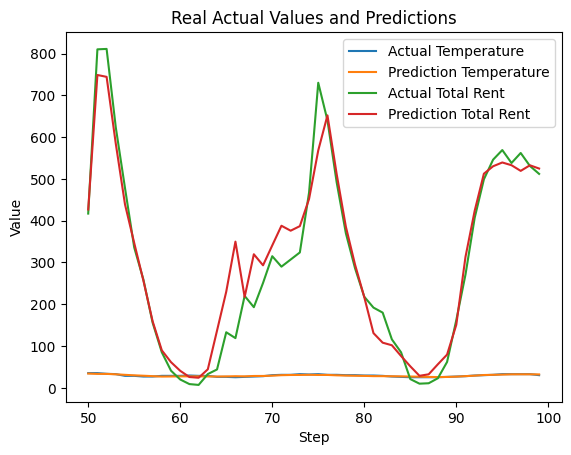

In [43]:
plt.figure(figsize=(10, 6))

pred_df[50:100].plot()

plt.title('Real Actual Values and Predictions')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()

plt.show()

Check List:
- Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel. ✔️
- Harus menggunakan LSTM dalam arsitektur model. ✔️
- Validation set sebesar 20% dari total dataset. ✔️
- Model harus menggunakan model sequential. ✔️
- Harus menggunakan Learning Rate pada Optimizer. ✔️
- MAE < 10% skala data. ✔️

Check List for 5 Stars:
- Semua ketentuan terpenuhi ✔️
- Dataset memiliki minimal 10000 sampel data ✔️
- MAE dari model < 10% skala data. ✔️
- Mengimplementasikan Callback. ✔️
- Membuat plot loss dan akurasi pada saat training dan validation. ✔️

In [44]:
dataset_size = len(ts_df)
print("Dataset size:", dataset_size) #Greater than 10.000 ✔️

Dataset size: 17379
